# PGA Tour Web Scraping and Machine Learning Project

AS an avid golf fan and asipring data scientist, I've always wanted to gather data from PGA Tour.com and do my own analysis on tour pro statistics. The following notebook walks you through my steps to collect, pre-process and clean, visualize and create a model to predict winners on the PGA. 

The data were collected from <a href='https://www.pgatour.com/'>pgatour.com</a> and includes PGA tour data from 2010-2017.

# <a id='TOC'>Table of Contents</a>
<ol>
<li><a href='#section 1'>Imports</a></li>
<li><a href='#section_2'>Data Collection, cleaning, and preprocessing</a></li>
<li><a href='#section_3'>Exploratory Data Analysis</a></li>
<li><a href='#section_4'>Train, fit, and test machine learning model</a></li>
<li><a href='#section_5'>Conclusion</a></li>



</ol>

# <a href='#section 1'>1. Imports</a>

The three imports I used for this notebook were requests, pandas, and beautiful soup.

In [1]:
#Imports
import requests
import pandas as pd
from bs4 import BeautifulSoup

# <a id='section_2'>2. Data Collection</a>
<a href='#TOC'>Back to table of Contents</a>

In order to collect the data I needed to perform the analysis, I had to utilize the beautiful soup package to web scrape the pgatour.com website. If you look at the <a href="https://www.pgatour.com/stats.html">PGA tour stats page</a>, you'll notice the statistics are contained in different pages. For example, putting, driving and scoring statistics are all contained in different pages. 

For each page I created a function that:
<ol>
<li>Pulls column headers</li>
<li>Pulls players from particular stats page</li>
<li>Pulls statistics from page</li>
<li>Create a dictionary to store player data in for particular stats page.</li>
<li>Uses functions 1-4 to create a pandas dataframe to store data for that particular statistic.</li>
<li>Loop through years 2010-2017 to create a dataframe from years 2010-2017</li>
<li>Store results in a sqlite3 database for future use.</li>
</ol>




### 1. Pull column headers from page

In [2]:
def get_headers(soup):
    '''This function get's the column names to use for the data frame.'''
    headers = []
    
    #Get rounds header
    rounds = soup.find_all(class_="rounds hidden-small hidden-medium")[0].get_text()
    headers.append(rounds)
    
    #Get other headers
    stat_headers = soup.find_all(class_="col-stat hidden-small hidden-medium")
    for header in stat_headers:
        headers.append(header.get_text())
    
    return headers

### 2. Pull players from page

In [3]:
#Get Players
def get_players(soup):
    '''This function takes the beautiful soup created and uses it to gather player names from the specified stats page.'''
    
    player_list = []
    
    #Get player as html tags
    players = soup.select('td a')[1:] #Use 1 beacuse first line of all tables is not useful.
    #Loop through list
    for player in players:
        player_list.append(player.get_text())
    
    return player_list

### 3. Pull statistics from page

In [4]:
##Get Stats
def get_stats(soup, categories):
    '''This function takes the soup created before and the number of categories needed to generate this'''
    
    #Finds all tags with class specified and puts into a list
    stats = soup.find_all(class_="hidden-small hidden-medium")
    
    #Initialize stats list
    stat_list = []
    
    #Loop through 
    for i in range(0, len(stats)-categories+1, categories):
        temp_list = []
        for j in range(categories):
            temp_list.append(stats[i + j].get_text())
        stat_list.append(temp_list)
            
    return stat_list

### 4. Create data dictionary for page

In [5]:
def stats_dict(players, stats):
        '''This function takes two lists, players and stats, 
        and creates a dictionary with the player being the key 
        and the stats as the vales (as a list)'''
    
        #initialize player dictionary
        player_dict = {}
    
        #Loop through player list
        for i, player in enumerate(players):
            player_dict[player] = stats[i]
    
        return player_dict

### 5. Use functions 1-4 to create dataframe for statistic. "make_dataframe"

In [6]:
##Mega function
def make_dataframe(url, categories):
        
    ##Create soup object from url.
    response = requests.get(url)
    text = response.text
    soup = BeautifulSoup(text, 'lxml')
    
    #1. Get Headers
    headers = get_headers(soup)
    
    #2. Get Players
    players = get_players(soup)
    
    #3. Get Stats
    stats = get_stats(soup, categories)
    
    #4. Make stats dictionary.
    stats_dictionary = stats_dict(players, stats)
    
    #Make dataframe
    frame = pd.DataFrame(stats_dictionary, index = headers).T
    
    #Reset index
    frame = frame.reset_index()
    
    #For each Dataframe, change index column to 'NAME'
    frame = frame.rename(index = str, columns = {'index': 'NAME'})
    return frame
  

### 6. Loop through years 2010-2017 to create a dataframe from years 2010-2017
All of the data cleaning and preprocessing happens in the next couple of code blocks.

In [12]:
years = [str(i) for i in range(2010, 2018)]
years

[2017]

In [13]:
for year in years:
    print(year)
    #Fedex cup points
    fcp = make_dataframe("https://www.pgatour.com/stats/stat.02671.{}.html".format(year), 6)[['NAME', 'POINTS']]
    #Top 10's and wins
    top10 = make_dataframe("https://www.pgatour.com/stats/stat.138.{}.html".format(year), 5)[['NAME', 'TOP 10', '1ST']]

    #Scoring statistics
    scoring = make_dataframe("https://www.pgatour.com/stats/stat.120.{}.html".format(year), 5)[['NAME', 'ROUNDS', 'AVG']]
    scoring = scoring.rename(columns={'AVG':'SCORING AVG'})

    #Driving Distance
    drivedistance = make_dataframe("https://www.pgatour.com/stats/stat.101.{}.html".format(year), 4)[['NAME', 'AVG.']]
    #Rename Columns
    drivedistance = drivedistance.rename(columns = {'AVG.':'AVG DRIVING DISTANCE.'})

    #Driving Accuracy
    driveacc = make_dataframe("https://www.pgatour.com/stats/stat.102.{}.html".format(year), 4)[['NAME', '%']]
    #Change column name from % to FWY %
    driveacc = driveacc.rename(columns = {'%': "FWY %"})

    #Greens in Regulation.
    gir = make_dataframe("https://www.pgatour.com/stats/stat.103.{}.html".format(year), 5)[['NAME', '%']]
    #Change column name from % to GIR %
    gir = gir.rename(columns = {'%': "GIR %"})

    #Strokes gained putting
    sg_putting = make_dataframe("https://www.pgatour.com/stats/stat.02564.{}.html".format(year), 4)[['NAME', 'AVERAGE']]
    #Change name of average column
    sg_putting = sg_putting.rename(columns = {'AVERAGE': 'AVG STROKES GAINED PUTTING'})

    #Strokes gained tee to green
    sg_teetogreen = make_dataframe("https://www.pgatour.com/stats/stat.02674.{}.html".format(year), 6)[['NAME', 'AVERAGE']]
    #Change name of average column
    sg_teetogreen = sg_teetogreen.rename(columns = {'AVERAGE' : 'AVG SG TEE TO GREEN'})

    #sg total
    sg_total = make_dataframe("https://www.pgatour.com/stats/stat.02675.{}.html".format(year), 6)[['NAME', 'AVERAGE']]
    sg_total = sg_total.rename(columns = {'AVERAGE':'AVG SG TOTAL'})
    
    #Get Dataframes into list.
    data_frames = [drivedistance, driveacc, gir, sg_putting, sg_teetogreen, sg_total]
    
    #Merge all Dataframes together
    df_one = pd.DataFrame()
    df_one = scoring
    for df in data_frames:
        df_one = pd.merge(df_one, df, on='NAME')
        
    

    #merge fex ex cup points
    df_one = pd.merge(df_one, fcp, how='outer', on='NAME')
    #Merge top 10's
    df_one = pd.merge(df_one, top10, how='outer', on='NAME')
    
    #Only get people who's scoring average isn't null.
    df_one = df_one.loc[df_one['SCORING AVG'].isnull() == False]  
    
    #Add year column
    df_one['Year'] = year
    
    #Concat dataframe to overall dataframe
    
    if year == 2010:
        df_total = pd.DataFrame()
        df_total = pd.concat([df_total, df_one], axis=0)
    else:
        df_total = pd.concat([df_total, df_one], axis=0)
    
    
    
    

    
    
    
    
    
    
        

2017


In [15]:
#Get rid of comma in points column
#df_2017['POINTS'] = df_2017['POINTS'].apply(lambda x: str(x).replace(',', ''))
    
#Turn columns to numeric
df_total[['1ST', 'ROUNDS', "TOP 10", 'SCORING AVG', 'AVG DRIVING DISTANCE.',
       'FWY %', 'GIR %', 'AVG STROKES GAINED PUTTING', 'AVG SG TEE TO GREEN', 'AVG SG TOTAL']] = df_total[['1ST', 'ROUNDS', "TOP 10", 'SCORING AVG', 'AVG DRIVING DISTANCE.',
       'FWY %', 'GIR %', 'AVG STROKES GAINED PUTTING', 'AVG SG TEE TO GREEN', 'AVG SG TOTAL']].apply(pd.to_numeric)

#Create 300+ and winner column
df_total['300+'] = df_total['AVG DRIVING DISTANCE.'].apply(lambda x: 1 if x>=300 else 0)
df_total['Winner'] = df_total['1ST'].apply(lambda x: 1 if x >= 1 else 0)

#Fill na values with zeros
df_total.fillna(0, inplace=True)

In [16]:
df_total = df_total[['NAME', 'Year', 'POINTS', '1ST', 'TOP 10', 'ROUNDS', 'SCORING AVG',
                   'AVG DRIVING DISTANCE.', 'AVG SG TEE TO GREEN', 'AVG STROKES GAINED PUTTING', 'AVG SG TOTAL',
                   'FWY %', 'GIR %', '300+', 'Winner']]

In [17]:
df_total['POINTS'] = df_total['POINTS'].apply(lambda x: str(x))

In [18]:
df_total['POINTS'] = df_total['POINTS'].apply(lambda x: x.replace(',', ''))

In [19]:
df_total['POINTS'] = df_total['POINTS'].apply(pd.to_numeric)

### 7. Store Data in Sqlite3 database

In [20]:
#Load sqlite package
import sqlite3 as db
#Create connect object with example db. A new file will be created.
conn = db.connect('pgatour.db')

#Create cursor to perform actions on db.
c = conn.cursor()

In [21]:
df_total.to_sql("pgatour", conn, if_exists='replace')

C:\Users\daron\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:1362: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


# 3. <a id='section_3'>Exploratory Data Analysis</a>
<a href='#TOC'>Back to table of Contents</a>


First, I'll take a look at the .info(), .describe(), and head methods to get a feel for the dataset.

In [27]:
df = pd.read_sql_query("select * from pgatour;", conn).drop('index', axis=1).set_index('NAME').reset_index()

In [28]:
df.head()

,NAME,Year,POINTS,1ST,TOP 10,ROUNDS,SCORING AVG,AVG DRIVING DISTANCE.,AVG SG TEE TO GREEN,AVG STROKES GAINED PUTTING,AVG SG TOTAL,FWY %,GIR %,300+,Winner
0,Aaron Baddeley,2010,559,0.0,2.0,94,70.995,298.9,-0.294,0.509,0.208,56.65,64.60,0,0
1,Adam Scott,2010,640,1.0,4.0,70,70.468,294.4,1.609,-0.746,0.862,62.93,69.61,0,1
2,Alex Cejka,2010,489,0.0,4.0,81,71.219,277.4,0.396,-0.466,-0.073,70.31,66.60,0,0
3,Alex Prugh,2010,526,0.0,4.0,88,70.878,295.7,-0.112,0.202,0.092,58.40,68.60,0,0
4,Andres Romero,2010,853,0.0,2.0,73,70.986,296.0,-0.118,0.254,0.136,55.05,65.07,0,0


In [98]:
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1485 entries, 0 to 184
Data columns (total 15 columns):
NAME                          1485 non-null object
Year                          1485 non-null object
POINTS                        1485 non-null int64
1ST                           1485 non-null float64
TOP 10                        1485 non-null float64
ROUNDS                        1485 non-null int64
SCORING AVG                   1485 non-null float64
AVG DRIVING DISTANCE.         1485 non-null float64
AVG SG TEE TO GREEN           1485 non-null float64
AVG STROKES GAINED PUTTING    1485 non-null float64
AVG SG TOTAL                  1485 non-null float64
FWY %                         1485 non-null float64
GIR %                         1485 non-null float64
300+                          1485 non-null int64
Winner                        1485 non-null int64
dtypes: float64(9), int64(4), object(2)
memory usage: 225.6+ KB


Observations: 1485 total rows, no missing data, 15 total columns, 13 are numeric and 2 are not (year and Name)

In [99]:
df_2017.describe()

,POINTS,1ST,TOP 10,ROUNDS,SCORING AVG,AVG DRIVING DISTANCE.,AVG SG TEE TO GREEN,AVG STROKES GAINED PUTTING,AVG SG TOTAL,FWY %,GIR %,300+,Winner
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,682.694276,0.233670,2.660606,78.449832,70.928214,290.050168,0.120712,0.021855,0.142578,61.434310,65.567273,0.124579,0.183838
std,524.100289,0.574572,2.450720,14.266512,0.688331,8.733330,0.639291,0.347419,0.692763,5.079918,2.705614,0.330352,0.387483
min,0.000000,0.000000,0.000000,45.000000,68.827000,266.400000,-3.340000,-1.475000,-3.209000,43.020000,53.540000,0.000000,0.000000
25%,322.000000,0.000000,1.000000,68.000000,70.503000,284.200000,-0.265000,-0.193000,-0.266000,57.950000,63.760000,0.000000,0.000000
50%,549.000000,0.000000,2.000000,79.000000,70.909000,289.700000,0.133000,0.039000,0.139000,61.430000,65.730000,0.000000,0.000000
75%,937.000000,0.000000,4.000000,89.000000,71.348000,295.600000,0.535000,0.257000,0.564000,64.900000,67.420000,0.000000,0.000000
max,4750.000000,5.000000,15.000000,120.000000,74.400000,318.400000,2.347000,1.130000,2.406000,76.880000,73.520000,1.000000,1.000000


In [137]:
df.groupby('Winner').count()

,NAME,Year,POINTS,1ST,TOP 10,ROUNDS,SCORING AVG,AVG DRIVING DISTANCE.,AVG SG TEE TO GREEN,AVG STROKES GAINED PUTTING,AVG SG TOTAL,FWY %,GIR %,300+
Winner,,,,,,,,,,,,,,
0,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372,1372
1,305,305,305,305,305,305,305,305,305,305,305,305,305,305


One important thing I will keep in mind when implementing my final machine learning algorithm is the imbalance in the Winner (1) vs non-winner class(0). Because there is this imbalance, it might be difficult for the algorithm to detect winners.

### Vizualizations

In [29]:
#Import plotting libs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Scoring Average Over Time

Text(0.5,1,'Scoring Averages Since 2010 on PGA Tour')

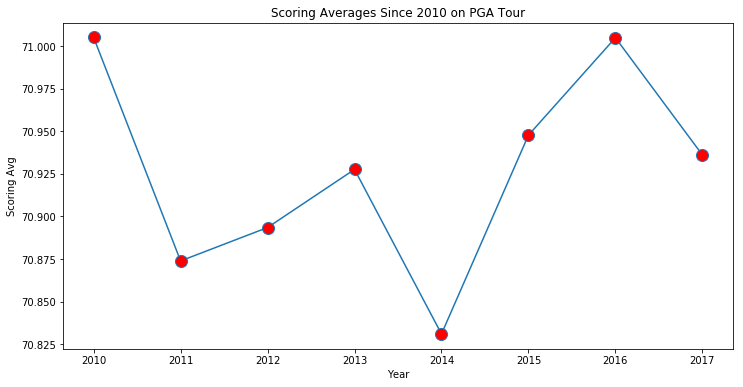

In [94]:
plt.figure(figsize=(12, 6))
plt.plot(df.groupby('Year').mean()['SCORING AVG'], marker='o', markerfacecolor='red', markersize = 12)
plt.xlabel('Year')
plt.ylabel('Scoring Avg')
plt.title('Scoring Averages Since 2010 on PGA Tour')

Observations: Scoring Average for players on the PGA tour has varied over time. 


### Scatterplot of AVG DRIVING DISTANCE. VS FWY %

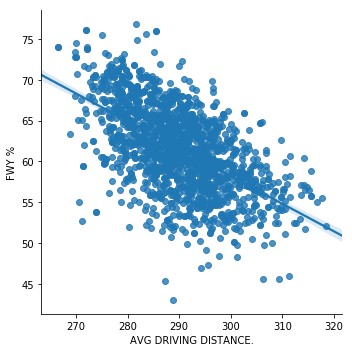

In [101]:
sns.lmplot(x='AVG DRIVING DISTANCE.', y='FWY %', data=df)

Observations: AVG DRIVING DISTANCE is negatively correlated with FWY %

### FED EX Cup Points Over Time Separated by avg drivers over 300 yards and not over 300 yards

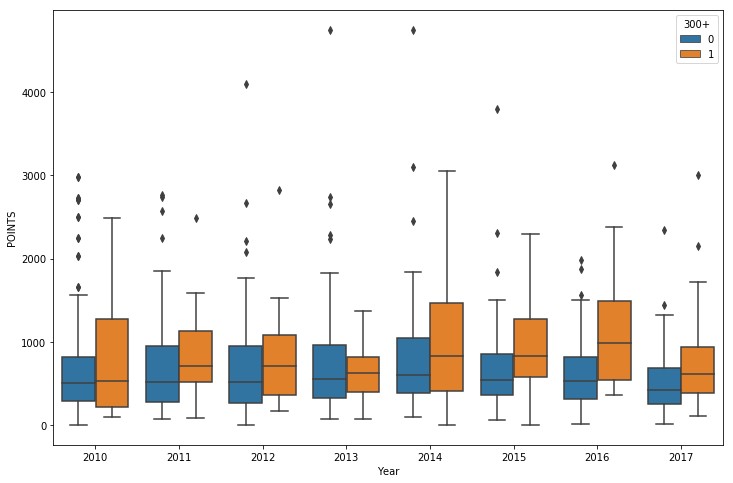

In [100]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Year', y='POINTS', hue='300+', data=df)

Observations: With the exception of the 2013 season, individuals who drove the ball over 300 yards tended to gain more fex ex cup points on average.

### Average driving distance over time broken separated by winners and non winners

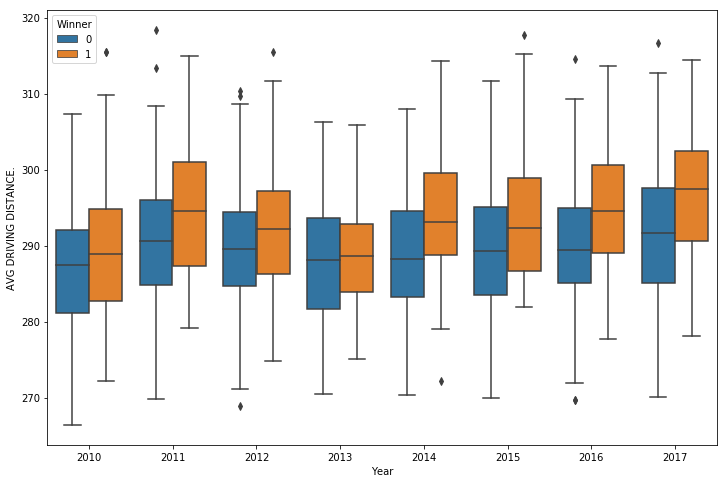

In [99]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Year', y='AVG DRIVING DISTANCE.', hue='Winner', data=df)

Observations: Tournament winners tend to drive the ball further than non-tournament winners

### Scoring Average Over time separated by 300+ drivers.

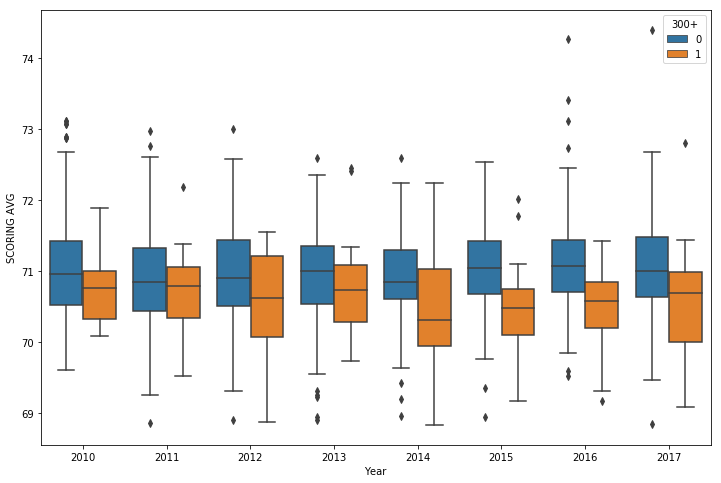

In [103]:
plt.figure(figsize=(12, 8))
sns.boxplot(x = 'Year', y = 'SCORING AVG', hue='300+', data = df)

Observations: Longer drivers tend to have a lower scoring average.

### Fairway % over time separated by tournament and non-tournament winners

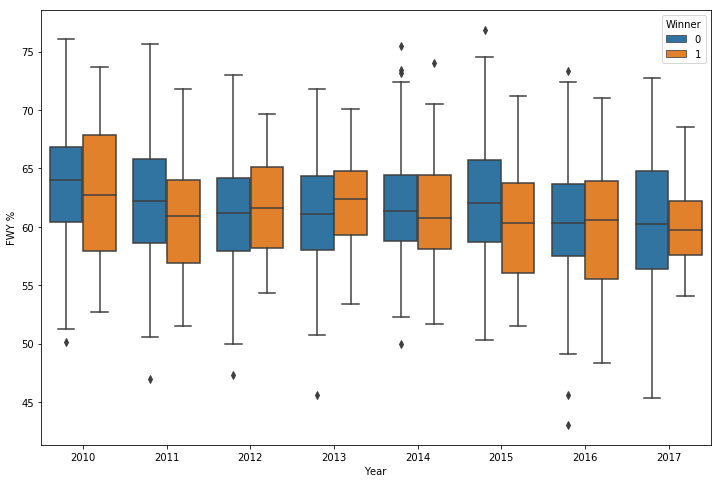

In [132]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Year', y='FWY %', hue='Winner', data=df_total)

Observations: There doesn't appear to be a trend with winning tournaments and Fairway %

### Number of individuals who drive the ball over 300 yards for each year in dataset

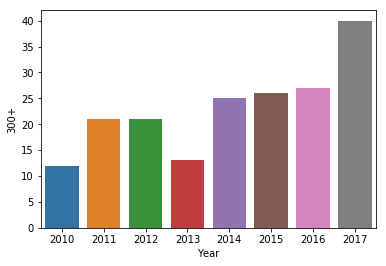

In [104]:
sns.barplot(x = 'Year', y = '300+', data = df_2017.groupby('Year').sum().reset_index())

Observations: Since 2010, the number of individuals who drive the ball over 300 yards on average has increased since 2010.

### Distribution of scoring average column

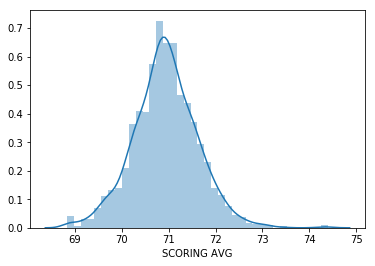

In [107]:
sns.distplot(df_2017['SCORING AVG'])

Observations: Scored look approximately normally distributed, a few outliers on the higher end of the distribution. Scoring average for all golfers across all years is 70.9 with a standard deviation of 0.688.

In [109]:
df_2017.describe()['SCORING AVG']

count    1485.000000
mean       70.928214
std         0.688331
min        68.827000
25%        70.503000
50%        70.909000
75%        71.348000
max        74.400000
Name: SCORING AVG, dtype: float64

### Barplot of top 10's vs Scoring Average.

[(68, 73),
 Text(0,0.5,'Scoring Average'),
 Text(0.5,1,"# of top 10's vs scoring average")]

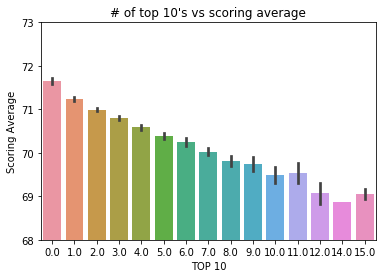

In [110]:
bp = sns.barplot(x="TOP 10",y='SCORING AVG', data = df_2017)
bp.set(ylim=(68, 73), title="# of top 10's vs scoring average", ylabel="Scoring Average")

Observations: As the number of top 10's increase, scoring average tends to decrease.

### Barplot of Fedex cup points vs Number of top 10's

[Text(0,0.5,'Fedex Cup Points'),
 Text(0.5,1,"# of top 10's vs Fedex Cup Points")]

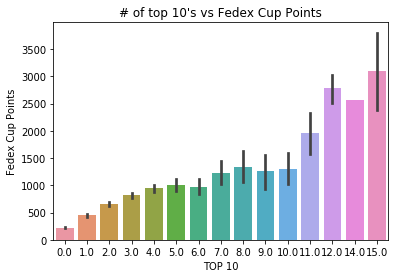

In [111]:
bp = sns.barplot(x="TOP 10",y='POINTS', data = df_2017)
bp.set(title="# of top 10's vs Fedex Cup Points", ylabel="Fedex Cup Points")

Observations: As the number of top 10's increase, Fedex cup points tend to increase. This makes sense intuitively because more fed ex cup points are awarded for top 10 finishes.

## Boxplots of all numeric columns based on winners and non-winners

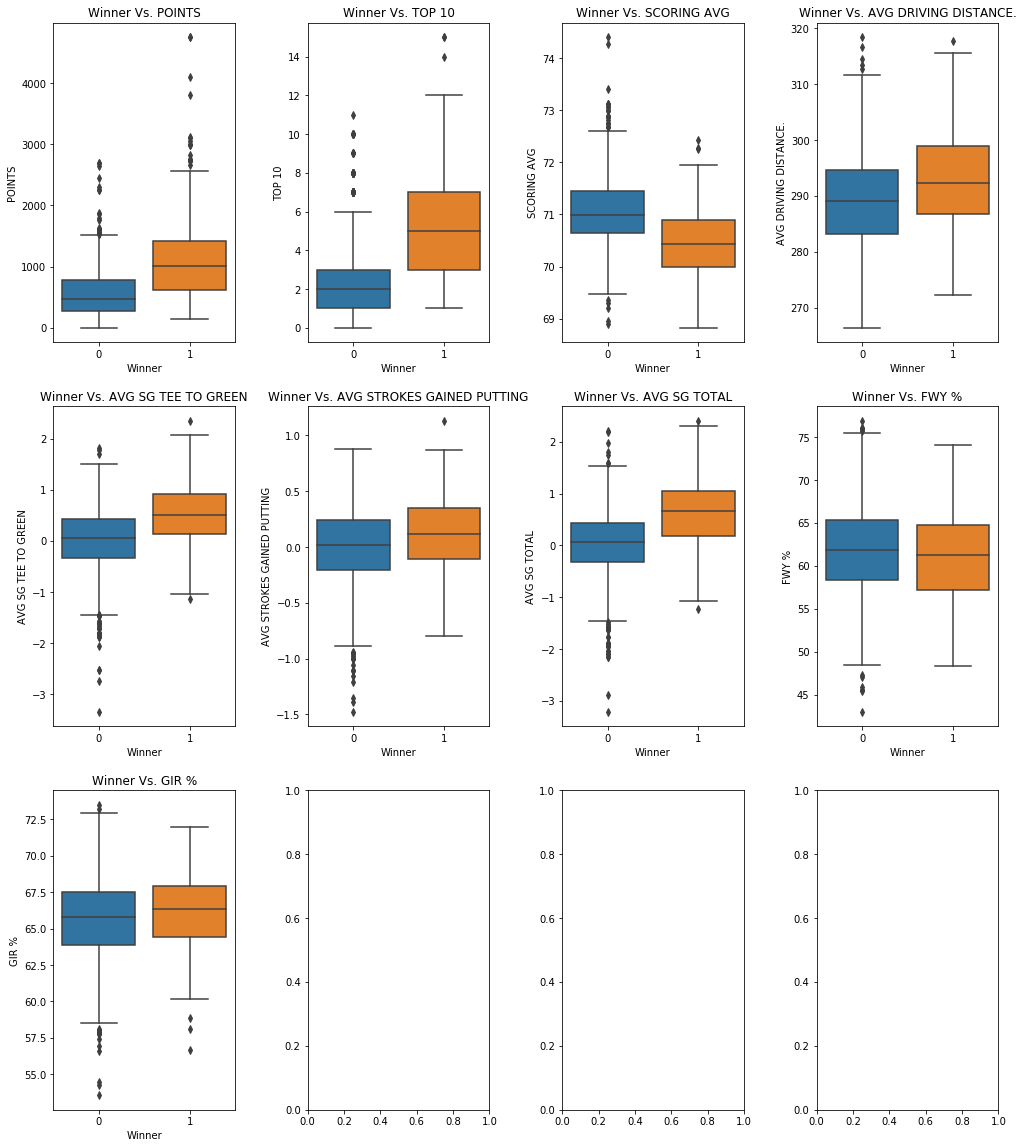

In [104]:
f, ax = plt.subplots(nrows = 3, ncols = 4, figsize=(15,20))
columns = ['POINTS', 'TOP 10', 'SCORING AVG',
       'AVG DRIVING DISTANCE.', 'AVG SG TEE TO GREEN',
       'AVG STROKES GAINED PUTTING', 'AVG SG TOTAL', 'FWY %', 'GIR %']
row = 0
col = 0
for i, column in enumerate(columns):
    g = sns.boxplot(x='Winner', y=column, ax=ax[row][col], data=df)
    g.set(title = "Winner Vs. " + column)
    col += 1
    if col == 4:
        col = 0
        row += 1
        
plt.subplots_adjust(left=None, bottom=None, right=1, top=None, wspace=.4, hspace=None)


# 4. <a id='section_4'>Train, fit, and test machine learning model</a>
<a href='#TOC'>Back to table of Contents</a>

In order to predict winners from the 2017 season, I'm going to use a Random Forest Classification model because of it's ability to be trained on different parts of the same training set and as a result reducing the variance (overfitting) in the final model. The steps I will take to build this model are listed below.
<ol>
<li>Import machine learning modules</li>
<li>Select features to run model on</li>
<li>Separate data into training and testing sets</li>
<li>Build model and create predictions</li>
</ol>


### Import machine learning modules

In [120]:
from sklearn.model_selection import train_test_split #Train test splits
from sklearn.linear_model import LogisticRegression #Logistic regression
from sklearn.metrics import classification_report #Classification report metrics
from sklearn.metrics import confusion_matrix #Confusion matrix
from sklearn.ensemble import RandomForestClassifier #Random Forest Classifier

### Select features to run model on

I'd like to run this model on all of the numerical columns except for # of wins. I'm leaving out # of wins because that inherently will predict a winner perfectly because if they do have any wins on the year, the model will predict them as a winner. 

### Scale Features

In [121]:
X = df_feat[['POINTS', 'TOP 10', 'ROUNDS', 'SCORING AVG',
       'AVG DRIVING DISTANCE.', 'AVG SG TEE TO GREEN',
       'AVG STROKES GAINED PUTTING', 'AVG SG TOTAL', 'FWY %', 'GIR %', '300+']]
y = df['Winner']

### Separate data into Training and Testing data sets

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)

### Build model and create predictions

In [123]:
rfc = RandomForestClassifier(n_estimators=200)

In [124]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
rfc_pred = rfc.predict(X_test)

In [127]:
cf_dat = confusion_matrix(y_test, rfc_pred)
cf_dat

array([[437,  20],
       [ 45,  52]], dtype=int64)

In [128]:
confusion = pd.DataFrame(data = cf_dat)

In [134]:
confusion

,0,1
0,437,20
1,45,52


In [135]:
print(classification_report(y_test, rfc_pred))

             precision    recall  f1-score   support

          0       0.91      0.96      0.93       457
          1       0.72      0.54      0.62        97

avg / total       0.87      0.88      0.88       554



# 5. <a id='section_5'>Conclusion</a>
<a href='#TOC'>Back to table of Contents</a>

### Notebook Observations
This notebook shows some interesting trends for winners on the PGA tour that I intend to explore further.
<ul>
<li>Winners on the PGA tour tend to hit the ball further than non-winners. Does hitting the ball further provide more value for PGA tour players than hitting it straighter?</li>
<li>The number of individuals that hit the ball over 300 yards jumped from 25 in 2016 to 41 in 2017. What is causing this huge spike in long drivers? Can we expect this to increase at the same rate? How will this impact future tour events?</li>
<li>Stroked gained putting and driving distance both appear to increase the chance of winning. Is it more important to drive the ball further or putt better? As they say, "Drive for show, putt for dough".</li>
</ul>

### Machine Learning Model Results
Based on the confusion matrix above, of the 72 tournament winners the model predicts, 52 of those are actually winners (precision - 72%). Addititionally, of the 97 actual winners in the test data set, the model correctly classified 52 of them (recall - 54%). One reason this model's prediction accuracy for tournament winners is so low is due to the class imbalance in the response variable (Winner) as stated previously.

### Moving Forward
I intend to take a deeper dive into the questions I stated above regarding driving distance vs accuracy and driving distance vs putting. As I continue to improve my knowledge of machine learning models and what improves prediction accuracy for this type of dataset I will update this notebook with any improvement I can make to the model.

I hope you enjoyed reading this notebook!